# Step0: defineProb_statement

**Objective**

To develop a machine learning (DNN) model using a Mulit-layer perceptron (MLP or Multi-Variant) to forecast the closing price of TCS stock for the next 5 days when dataset ended, also plot the trained of close over the whole data based on historical stock price data.




**Step-Taken**


# Step1: Load_Data

In [53]:
# import req library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Data in format y-m-d

In [54]:
# Load the dataset

file_path = '/content/cleanData_TCS_25Aug2004_5sep2024_NSE.csv'
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d') # Changed %y to %Y

## s(i) EDA

EDA = Exploratory data analysis

In [55]:
# import ydata python library instead of pandas-profiling

# !pip install ydata-profiling

# from ydata_profiling import ProfileReport

# # create profile
# profile = ProfileReport(data)

# # save report
# profile.to_file(output_file='output_TCS.html')

## s(ii) Trail_01_deleteLast_5rows

In [56]:

file_path = '/content/cleanData_TCS_25Aug2004_5sep2024_NSE.csv'

data = pd.read_csv(file_path)
# Display the original dataset
print("Original dataset:")
print(data)

# Remove the last 5 rows
data = data[:-5]

# Display the updated dataset
print("\nUpdated dataset (last 5 rows removed):")
print(data)


Original dataset:
            Date      Open      High       Low     Close       Volume
0     2004-08-25  1,198.70  1,198.70       979    987.95  1,71,16,372
1     2004-08-26       992       997     975.3       979    50,55,400
2     2004-08-27     982.4     982.4    958.55    962.65    38,30,750
3     2004-08-30     969.9       990       965    986.75    30,58,151
4     2004-08-31     986.5       990       976     988.1    26,49,332
...          ...       ...       ...       ...       ...          ...
4962  2024-08-30  4,500.00  4,592.25  4,487.80  4,553.75    36,37,222
4963  2024-09-02  4,576.00  4,588.00  4,512.00  4,521.05    12,16,500
4964  2024-09-03  4,521.05  4,555.90  4,495.90  4,512.35    17,17,263
4965  2024-09-04  4,476.95  4,487.00  4,436.70  4,479.25    12,65,505
4966  2024-09-05  4,481.00  4,499.00  4,454.15  4,475.95    16,88,793

[4967 rows x 6 columns]

Updated dataset (last 5 rows removed):
            Date      Open      High       Low     Close       Volume
0     2

# Step2: Data_PreProcessing

## s(i) assign_Dep_Indep_Variable

In [57]:
# Independent variables (X-axis): 'Open', 'Low', 'High', 'Adj Close', 'Volume'
# Dependent variable (Y-axis): 'Close'


X = data[['Open', 'Low', 'High', 'Volume']].values

# X = data[['Close']].values  #for univariant
Y = data['Close'].values

In [58]:
X

array([['1,198.70', '979', '1,198.70', '1,71,16,372'],
       ['992', '975.3', '997', '50,55,400'],
       ['982.4', '958.55', '982.4', '38,30,750'],
       ...,
       ['4,505.00', '4,486.80', '4,510.00', '9,30,697'],
       ['4,498.75', '4,457.30', '4,562.50', '18,48,058'],
       ['4,460.00', '4,460.00', '4,556.00', '21,33,641']], dtype=object)

## s(ii) Normalize_MinMax_Scale

In [59]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Replace commas in numerical columns with empty strings and convert to numeric

for col in ['Open', 'Low', 'High', 'Volume', 'Close']: # Include 'Close' in the loop

    if data[col].dtype == object:
        data[col] = pd.to_numeric(data[col].str.replace(',', ''), errors='coerce')
    else:
      pass



# Now, redefine X and Y using the updated 'data'
X = data[['Open', 'Low', 'High', 'Volume']].values
Y = data['Close'].values


scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

In [60]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

Why 60?

Ans: In summary, look_back = 60 means you are using the previous 60 time steps of data to predict the next time step in your time series prediction task. Adjusting this parameter might affect how your model learns from historical data and predicts future values.



*   The choice of look_back = 60 in our example suggests that we are using 60 previous time steps (or data points) to predict the next data point in our time series.




In [61]:
# Create a function to create sequences for LSTM

def create_sequences(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)


time_steps = 60  # Use the past 60 days to predict the next day
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, time_steps)

## s(iii) split_TrainTest

In [62]:
# Split the data into training and test sets


train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing


X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Step3: Build_LSTM_Model

To convert your existing model into a Stacked LSTM model, you need to add additional LSTM layers where the return_sequences=True parameter is used in each LSTM layer, except for the final LSTM layer (which should return only the last output). Stacked LSTM models involve stacking multiple LSTM layers on top of each other, where each LSTM layer feeds its outputs as inputs to the next one.

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [64]:

# Define the Stacked LSTM model
model = Sequential()

# ---- Input Layer + First Hidden Layer ----
# First LSTM layer - Input Layer and First Hidden Layer
# The input shape (X_seq.shape[1], X_seq.shape[2]) corresponds to the number of time steps and features
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))  # Input + Hidden
model.add(Dropout(0.2))  # Dropout for regularization

# ---- Second Hidden Layer ----
# Second LSTM layer - Second Hidden Layer
model.add(LSTM(units=50, return_sequences=True))  # Hidden
model.add(Dropout(0.2))  # Dropout for regularization

# ---- Third Hidden Layer ----
# Third LSTM layer - Third Hidden Layer
model.add(LSTM(units=50, return_sequences=False))  # Hidden
model.add(Dropout(0.2))  # Dropout for regularization

# ---- Output Layer ----
# The Dense layer is the Output Layer, producing a single continuous value for regression
model.add(Dense(units=1))  # Output

# Compile the model with Adam optimizer and MSE loss for regression tasks
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to view the architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,451 (200.98 KB)

 Trainable params: 51,451 (200.98 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Define the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))



model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# summary of  modal

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 60, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

## s(i) Model_Summary_Visualize

In [67]:
# import req library

!sudo apt-get install graphviz

!pip install pydot

from tensorflow.keras.utils import plot_model


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


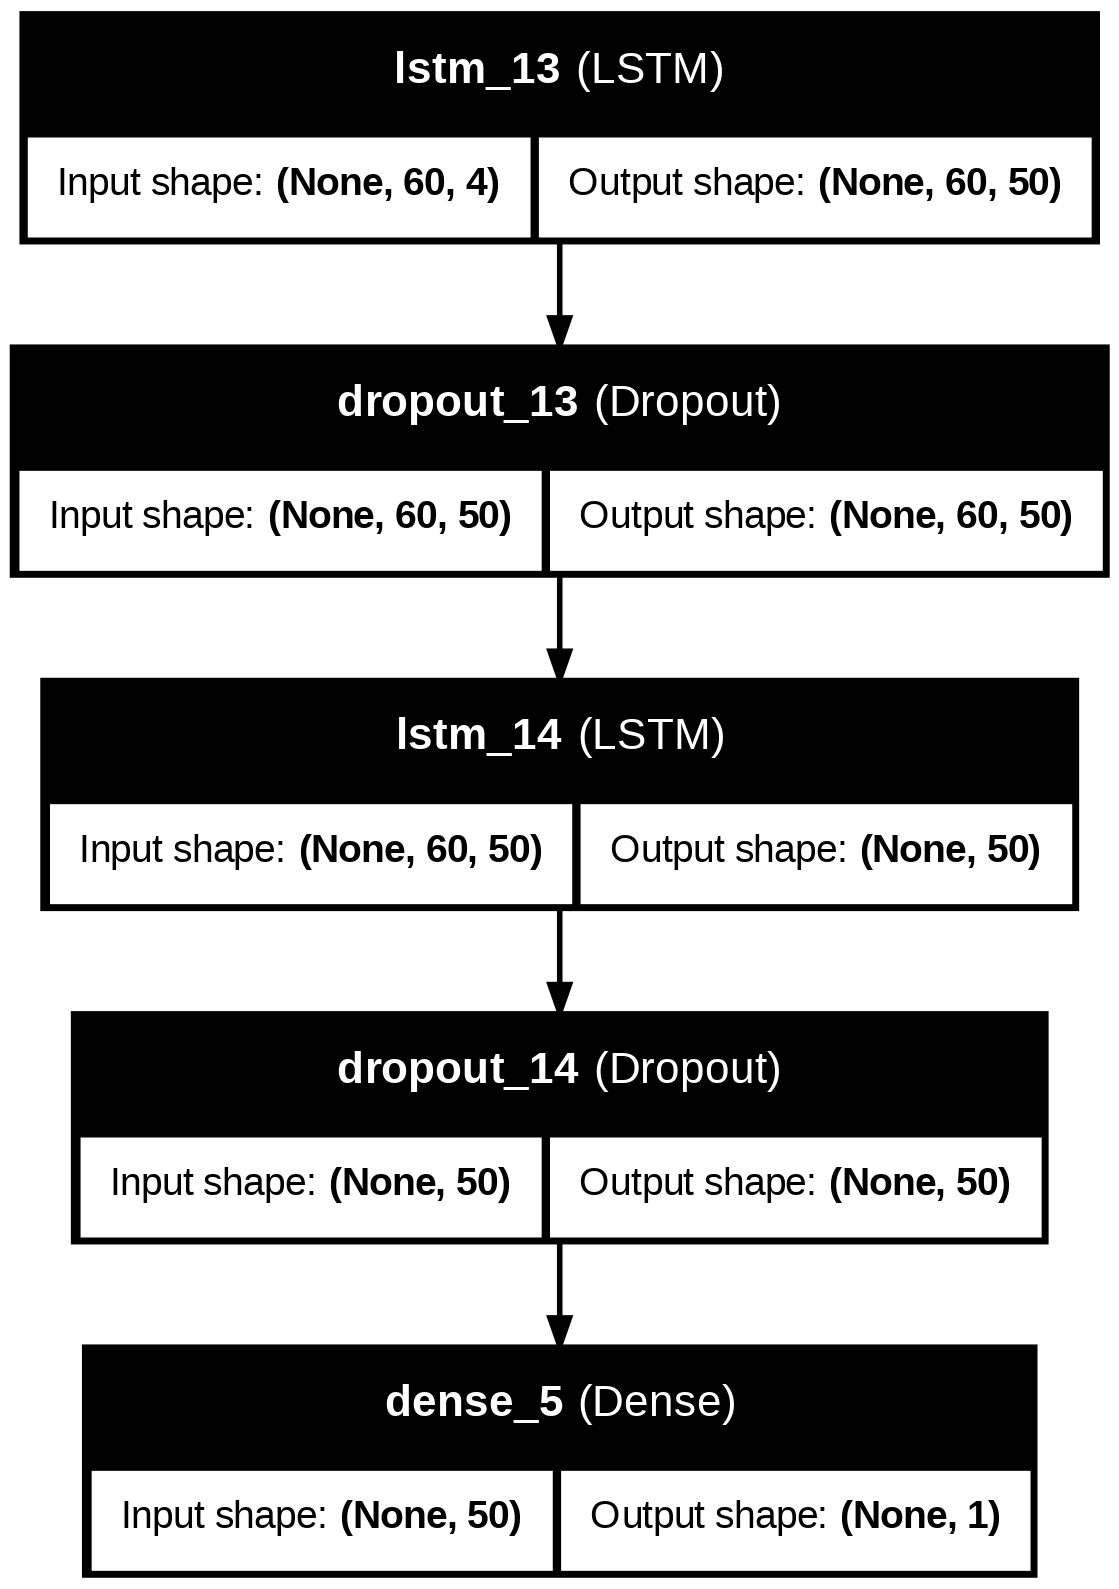

In [68]:
from tensorflow.keras.utils import plot_model

# Generate the plot and save it to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (if using a Jupyter notebook)
from IPython.display import Image
Image(filename='model_architecture.png')


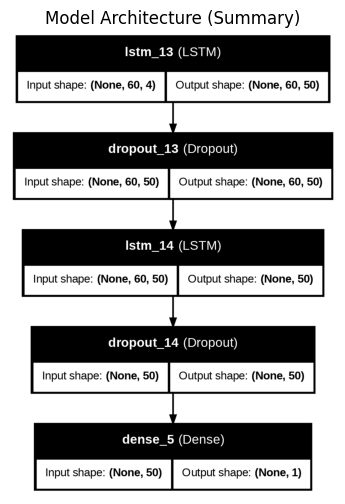

In [69]:
## If you are not using a Jupyter notebook, you can display the plot using matplotlib



img = plt.imread('model_architecture.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Model Architecture (Summary)')
plt.show()

## s(ii) Compile_Train

In [70]:
# Train the model

history = model.fit(X_seq, Y_seq, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - loss: 0.0130 - val_loss: 0.0035
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0010 - val_loss: 4.6736e-04
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 9.8066e-04 - val_loss: 0.0022
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 9.5599e-04 - val_loss: 0.0031
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 8.2088e-04 - val_loss: 0.0028
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.2049e-04 - val_loss: 7.0068e-04


# Step4: Forecaste

In [71]:
# Forecasting the next 5 days
def forecast(model, X, n_steps):
    forecasted = []
    current_step = X[-1]

    for _ in range(n_steps):
        current_step = current_step.reshape(1, time_steps, X.shape[2])
        predicted = model.predict(current_step)
        forecasted.append(predicted[0, 0])
        current_step = np.roll(current_step, -1, axis=1)
        current_step[0, -1, 0] = predicted

    return scaler_Y.inverse_transform(np.array(forecasted).reshape(-1, 1))

# Forecast the next 5 days
forecasted_prices = forecast(model, X_seq, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-71-05900ea78d19>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[0, -1, 0] = predicted


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [72]:
# Extract the last date in the dataset
last_date = pd.to_datetime(data['Date'].iloc[-1])

# Generate the next 5 dates
next_5_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 6)]

# next_5_dates

## s(i) Next_5days

In [73]:
# Print the next 5 days' closing prices with dates


for date, price in zip(next_5_dates, forecasted_prices):
    print(f" {date.strftime('%Y-%m-%d')} : {price[0]}")

 2024-08-30 : 4306.07470703125
 2024-08-31 : 4199.93408203125
 2024-09-01 : 4056.54150390625
 2024-09-02 : 3925.82666015625
 2024-09-03 : 3816.309326171875


## s(ii) plot_only5days

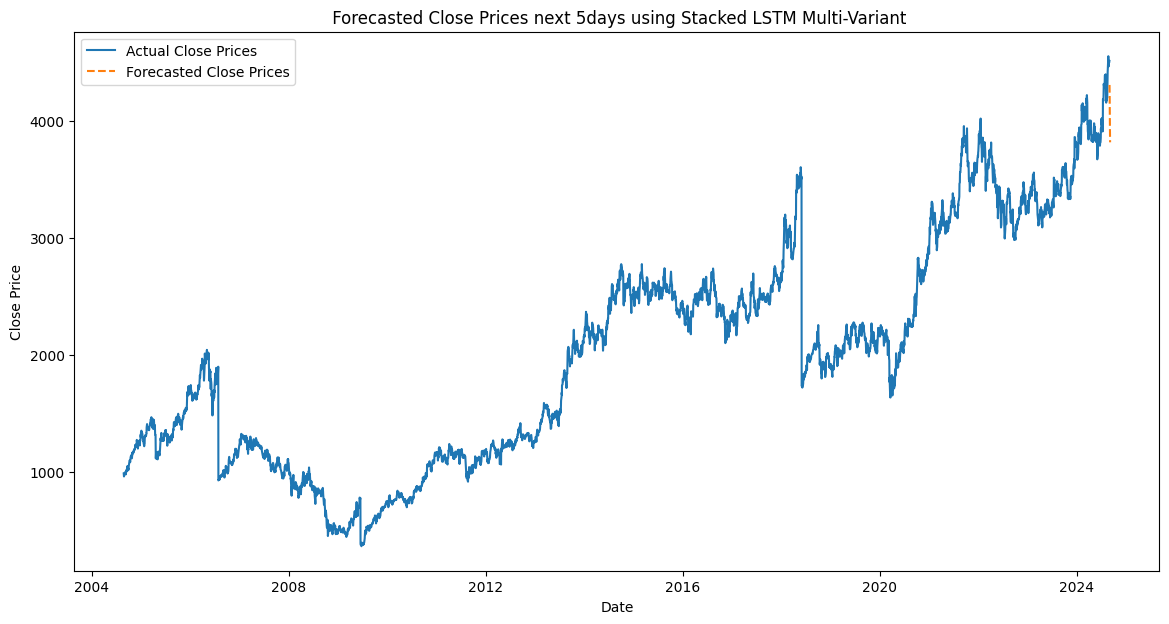

In [74]:
# Import necessary library
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the results
plt.figure(figsize=(14, 7))


# Convert 'Date' column to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    # Use '%Y-%m-%d' format for four-digit year
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Convert dates to naive timestamps if they are timezone-aware
plt.plot(data['Date'].dt.tz_localize(None), data['Close'], label='Actual Close Prices')


# Plot forecasted closing prices
forecasted_dates = pd.to_datetime(next_5_dates)
# Convert dates to naive timestamps if they are timezone-aware
plt.plot(forecasted_dates.tz_localize(None), forecasted_prices, label='Forecasted Close Prices', linestyle='--')



plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(' Forecasted Close Prices next 5days using Stacked LSTM Multi-Variant')
plt.legend()
plt.show()

## s(iii) Generate_Predication_EntireData

In [75]:
# Generate predictions for the entire dataset
predicted_prices = model.predict(X_seq)
predicted_prices = scaler_Y.inverse_transform(predicted_prices)

# Prepare data for plotting
actual_prices = scaler_Y.inverse_transform(Y_scaled[time_steps:])
dates = data['Date'][time_steps:]


154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


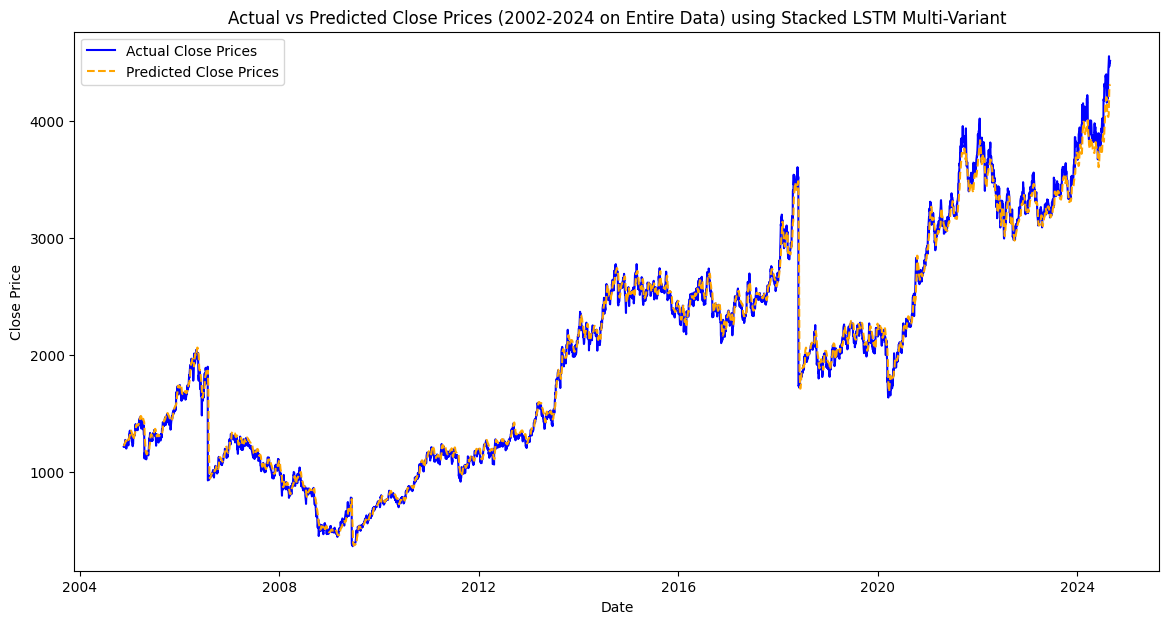

In [76]:
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot actual closing prices
plt.plot(dates, actual_prices, label='Actual Close Prices', color='blue')

# Plot forecasted closing prices
plt.plot(dates, predicted_prices, label='Predicted Close Prices', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices (2002-2024 on Entire Data) using Stacked LSTM Multi-Variant')
plt.legend()
plt.show()


## s(iv) see_accuracy_RMSE

In [77]:
from sklearn.metrics import mean_squared_error, r2_score

# Use the variables you calculated previously
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 6818.697308933937
R-squared: 0.99260201904327


In [78]:
# Import the necessary module for regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'actual_prices' and 'predicted_prices' from previous calculations are your true and predicted values
y_test = actual_prices
y_pred = predicted_prices

# Calculate appropriate metrics for regression problems
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the calculated metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 6818.697308933937
Root Mean Squared Error (RMSE): 82.57540377699607
Mean Absolute Error (MAE): 51.59947554589485
R-squared (R2): 0.99260201904327


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
